In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [98.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [992 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports In

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:


import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [ ]:
df=spark.read.csv('/content/iris_dataset.csv',inferSchema=True,header=True)

In [ ]:
print((df.count(),len(df.columns)))



(150, 5)


In [ ]:

df.show(10,False)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|5.1         |3.5        |1.4         |0.2        |setosa |
|4.9         |3.0        |1.4         |0.2        |setosa |
|4.7         |3.2        |1.3         |0.2        |setosa |
|4.6         |3.1        |1.5         |0.2        |setosa |
|5.0         |3.6        |1.4         |0.2        |setosa |
|5.4         |3.9        |1.7         |0.4        |setosa |
|4.6         |3.4        |1.4         |0.3        |setosa |
|5.0         |3.4        |1.5         |0.2        |setosa |
|4.4         |2.9        |1.4         |0.2        |setosa |
|4.9         |3.1        |1.5         |0.1        |setosa |
+------------+-----------+------------+-----------+-------+
only showing top 10 rows



In [ ]:
df.select('species').distinct().count()



3

In [ ]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:


input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)
final_data.show()


+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|
|         4.6|        3.4|         1.4|        0.3| setosa|[4.6,3.4,1.4,0.3]|
|         5.0|        3.4|         1.5|        0.2| setosa|[5.0,3.4,1.5,0.2]|
|         4.4|        2.9|         1.4|        0.2| setosa|[4.4,2.9,1.4,0.2]|
|         4.9|        3.1|         1.5|        0.1| setosa|[4.9,

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features', k=i)
    KMeans_fit=KMeans_algo.fit(final_data) 
    output=KMeans_fit.transform(final_data)
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.8501515983265806
Silhouette Score: 0.7354567373091194
Silhouette Score: 0.6093888373825749
Silhouette Score: 0.558790871218324
Silhouette Score: 0.647082755976482
Silhouette Score: 0.6265935589947064
Silhouette Score: 0.5809433730939685
Silhouette Score: 0.5569753285910741


In [ ]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)


Text(0, 0.5, 'cost')

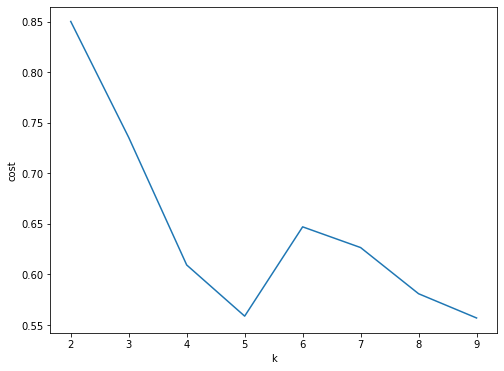

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
model = kmeans.fit(final_data)

In [ ]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   62|
|         0|   38|
+----------+-----+



In [ ]:


predictions=model.transform(final_data)



In [ ]:
predictions.columns


['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [ ]:


predictions.groupBy('species','prediction').count().show()



+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   14|
| virginica|         0|   36|
|versicolor|         0|    2|
|    setosa|         1|   50|
|versicolor|         2|   48|
+----------+----------+-----+



In [ ]:


pandas_df = predictions.toPandas()
pandas_df.sample(5)



,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
139,6.9,3.1,5.4,2.1,virginica,"[6.9, 3.1, 5.4, 2.1]",0
73,6.1,2.8,4.7,1.2,versicolor,"[6.1, 2.8, 4.7, 1.2]",2
88,5.6,3.0,4.1,1.3,versicolor,"[5.6, 3.0, 4.1, 1.3]",2
115,6.4,3.2,5.3,2.3,virginica,"[6.4, 3.2, 5.3, 2.3]",0
129,7.2,3.0,5.8,1.6,virginica,"[7.2, 3.0, 5.8, 1.6]",0


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

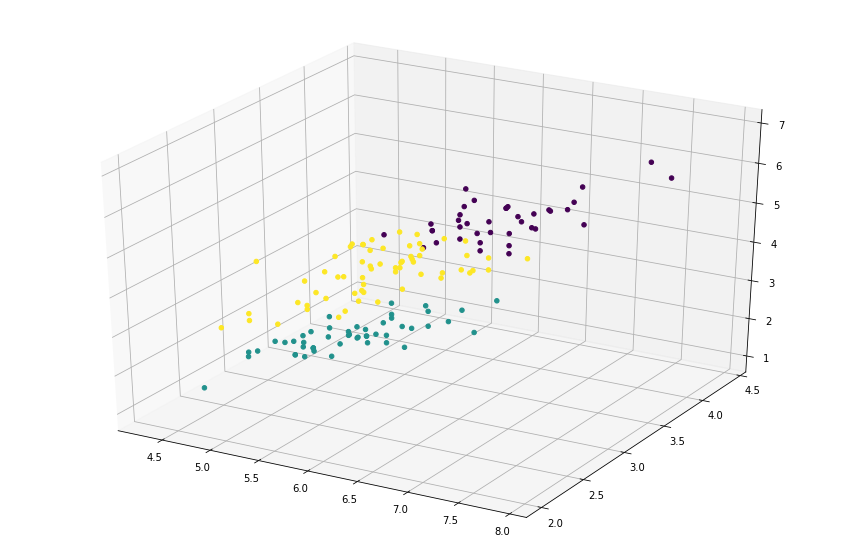

In [ ]:


cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()

